In [7]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import math
import gc

TODO things to try:
- instead of taking 10%, split data by prop_country_id (idea from #3)
- bounding numerical variables, i.e normalising
- now i just drop all columns with missing data, but the following is better:
  - #2 does something with matching/mismatching historical data and the given hotel data
  - #2 sets missing values of competitors to 0
  - #1 imputes everything with negative value (??? don't know what he means. probably worst case scenario? or -1?)
- normalise price w.r.t search_id or prop_id or search_desintation id, as this can differ really greatly
- original distance i now put mean for 40K missing values, but we should look at whole search query and take max or mean or something.

First, we randomly get 10% of the data as it is so big. According to the #1 winner of the competition, this is still enough data to get a really good performance. Also, the #3 has this approach mentioned in their powerpoint.

In [2]:
train = pd.read_csv("data/training_set_VU_DM.csv")
test = pd.read_csv("data/test_set_VU_DM.csv")

In [3]:
search_ids = train.srch_id.unique()
print(f'There are {len(search_ids)} searches in the training set and {len(train)} data points')
df = train
#df = train[train.srch_id.isin(random.sample(list(search_ids), int(0.1 * len(search_ids))))]
print(f'There are {len(df.srch_id.unique())} searches in the smaller training set and {len(df)} data points')

There are 199795 searches in the training set and 4958347 data points
There are 199795 searches in the smaller training set and 4958347 data points


In [4]:
search_ids_test = test.srch_id.unique()
print(f'There are {len(search_ids_test)} searches in the test set and {len(test)} data points')

There are 199549 searches in the test set and 4959183 data points


Next, we downsample the smaller training set as the data is very imbalanced. We take 5 negatives for every positive instance.

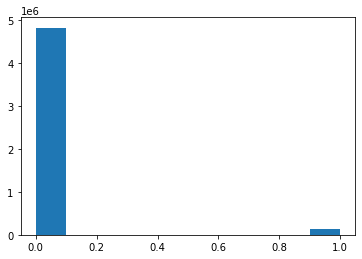

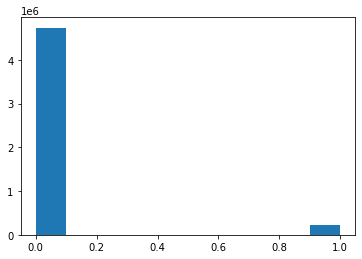

In [5]:
plt.hist(df.booking_bool)
plt.show()

plt.hist(df.click_bool)
plt.show()

In [6]:
keep = df[(df.booking_bool==1) | (df.click_bool==1)] # we want to keep all clicked and/or booked
avg_keep = keep.groupby('srch_id').size().mean() # average amount of clicks/bools per search
print(f'On average, there are {avg_keep} clicks/bookings per search')

majority = df[(df.booking_bool==0) & (df.click_bool==0)] # not clicked AND not booked
majority_keep = majority.groupby('srch_id').head(int(5*avg_keep)).reset_index(drop=True) # we take 5 negatives for every positive

On average, there are 1.1105332966290449 clicks/bookings per search


In [8]:
del df
gc.collect()

6498

In [9]:
downsampled = pd.concat([keep, majority_keep], ignore_index=True).sort_values('srch_id')

In [10]:
downsampled.head(n=2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,68914,2,3.0,...,NaN,NaN,NaN,NaN,0.0,0.0,11.0,1,114.29,1
221881,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


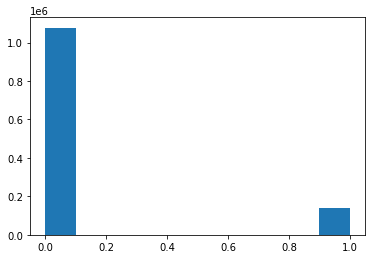

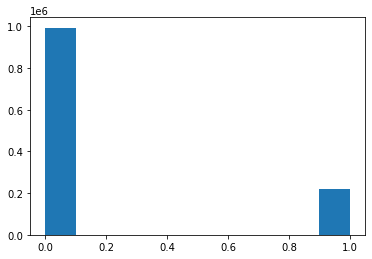

In [11]:
plt.hist(downsampled.booking_bool)
plt.show()

plt.hist(downsampled.click_bool)
plt.show()

In [12]:
downsampled.to_csv("data/training_set_VU_DM_small_downsampled.csv", index=False)

Missing value imputation

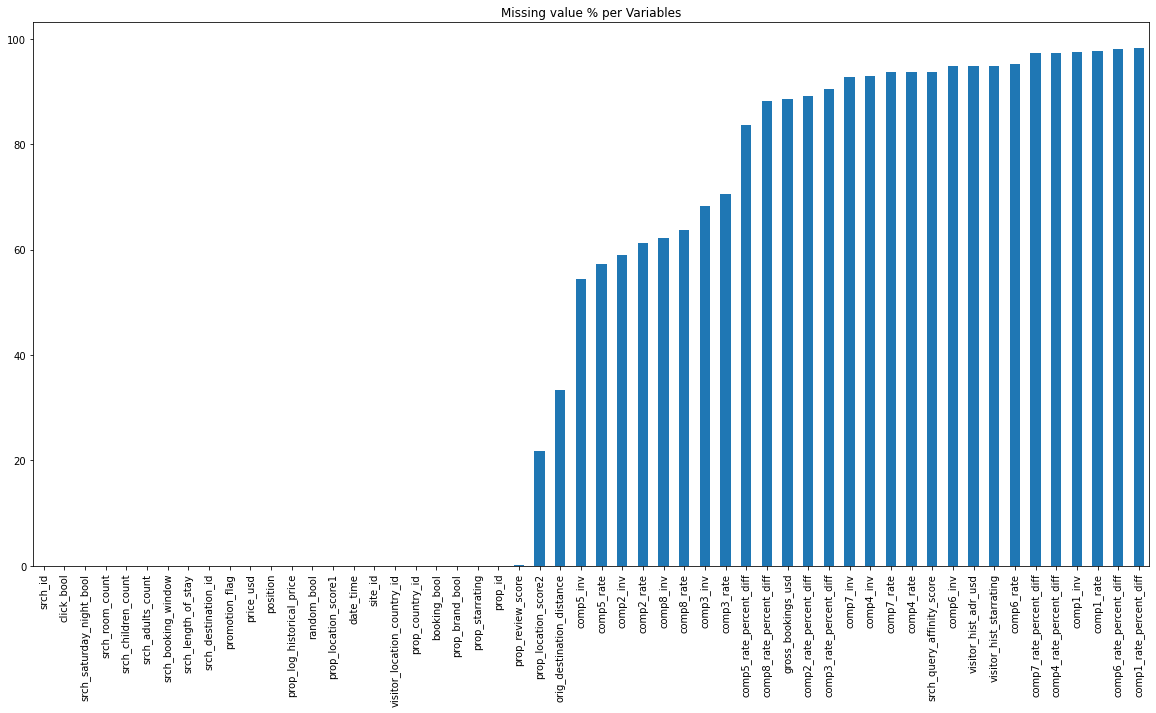

In [13]:
df = downsampled
del downsampled
gc.collect()

def plot_missing(data):
    missing = (data.isna().sum()/data.shape[0]*100) # missing percentages

    # plot missing 
    plt.figure(figsize=(20,10))
    missing.sort_values().plot(kind='bar')
    plt.title('Missing value % per Variables')
    
    return missing

missing = plot_missing(df)

In [14]:
discard = missing[missing>50]
print(discard)
df.drop(discard.index, axis=1, inplace=True)
test.drop(discard.index[:-1], axis=1, inplace=True) # test set doesnt have all columns so we do this in meanwhile

visitor_hist_starrating      94.799632
visitor_hist_adr_usd         94.773805
srch_query_affinity_score    93.741841
comp1_rate                   97.707489
comp1_inv                    97.519291
comp1_rate_percent_diff      98.195586
comp2_rate                   61.178491
comp2_inv                    58.962559
comp2_rate_percent_diff      89.042156
comp3_rate                   70.525466
comp3_inv                    68.186974
comp3_rate_percent_diff      90.551606
comp4_rate                   93.637625
comp4_inv                    92.895691
comp4_rate_percent_diff      97.290295
comp5_rate                   57.278730
comp5_inv                    54.425244
comp5_rate_percent_diff      83.699324
comp6_rate                   95.176111
comp6_inv                    94.750198
comp6_rate_percent_diff      98.094495
comp7_rate                   93.621010
comp7_inv                    92.747304
comp7_rate_percent_diff      97.198992
comp8_rate                   63.628191
comp8_inv                

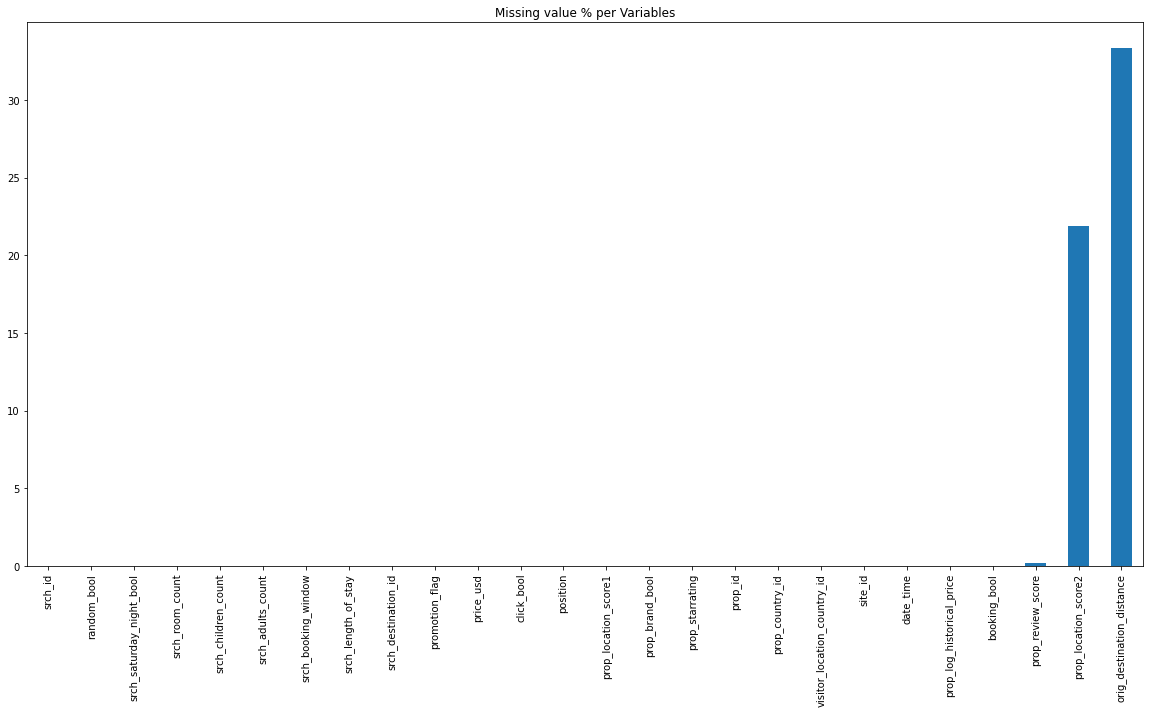

In [15]:
missing = plot_missing(df)

In [16]:
def impute(impute):

    # hotel properties: impute with worst case scenario. Stolen from #2 and #3
    impute[['prop_review_score', 'prop_location_score2']] = impute[['prop_review_score','prop_location_score2']].fillna(0)

    # set missing original distances to max() for each searchquery
    impute.fillna(impute.groupby('srch_id').transform('max').squeeze(), inplace=True)
    impute.orig_destination_distance.fillna(impute.orig_destination_distance.mean(), inplace=True) 
    # TODO just to remove nans, we should def not do this
    # TODO negative

impute(df)
impute(test)

In [17]:
df.describe()

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,...,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,click_bool,booking_bool
count,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06,...,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06,1.215741e+06
mean,1.664831e+05,1.014520e+01,1.741140e+02,1.724701e+02,3.066708e+04,3.164178e+00,3.755097e+00,6.249769e-01,2.791237e+00,1.132527e-01,...,2.395495e+00,3.787740e+01,1.983881e+00,3.741307e-01,1.125592e+00,5.054950e-01,1.308012e+03,3.045789e-01,1.825052e-01,1.138318e-01
std,9.610404e+04,7.740706e+00,6.640507e+01,6.892698e+01,3.267118e+04,1.087588e+00,1.082293e+00,4.841291e-01,1.537666e+00,1.628331e-01,...,2.085796e+00,5.289630e+01,8.818054e-01,7.547385e-01,4.379008e-01,4.999700e-01,1.660763e+03,4.602290e-01,3.862605e-01,3.176070e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.309900e+04,5.000000e+00,1.000000e+02,1.000000e+02,8.685000e+03,3.000000e+00,3.500000e+00,0.000000e+00,1.610000e+00,1.600000e-03,...,1.000000e+00,4.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,2.293600e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.666200e+05,5.000000e+00,2.190000e+02,2.190000e+02,1.838000e+04,3.000000e+00,4.000000e+00,1.000000e+00,2.710000e+00,4.250000e-02,...,2.000000e+00,1.700000e+01,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.308012e+03,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.498680e+05,1.400000e+01,2.190000e+02,2.190000e+02,3.844000e+04,4.000000e+00,4.500000e+00,1.000000e+00,3.950000e+00,1.572000e-01,...,3.000000e+00,4.900000e+01,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.308012e+03,1.000000e+00,0.000000e+00,0.000000e+00
max,3.327850e+05,3.400000e+01,2.310000e+02,2.300000e+02,1.408210e+05,5.000000e+00,5.000000e+00,1.000000e+00,6.980000e+00,1.000000e+00,...,5.700000e+01,4.920000e+02,9.000000e+00,9.000000e+00,8.000000e+00,1.000000e+00,1.164495e+04,1.000000e+00,1.000000e+00,1.000000e+00


Create new target, i.e relevance

In [18]:
df['target'] = np.where(df.click_bool == 1, 1,0)
df['target'] = np.where(df.booking_bool == 1, 5, df.target)

In [19]:
df.loc[:,['target', 'click_bool', 'booking_bool']].head(n=20)

,target,click_bool,booking_bool
0,5,1,1
221881,0,0,0
221882,0,0,0
221883,0,0,0
221880,0,0,0
221879,0,0,0
1,1,1,0
221884,0,0,0
221885,0,0,0
221886,0,0,0


In [ ]:
df.to_csv("data/dummy/train.csv", index=False)
test.to_csv("data/dummy/test.csv", index=False)